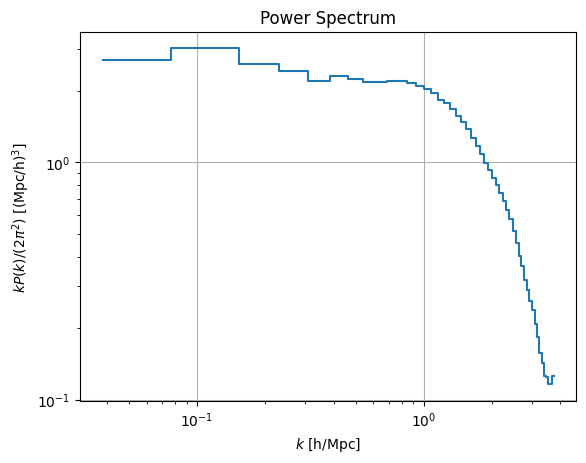

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load overdensity
delta = np.load("/gpfs/nchugh/dmcoords/tng300_snap99_overdensity_128^3.npy")

N = delta.shape[0]

# Box size from metadata (in Mpc/h)
Lx, Ly, Lz = 205.0, 186.295, 168.848
volume = Lx * Ly * Lz

# FFT
delta_k = np.fft.fftn(delta)

# Power spectrum 3D
P3D = np.abs(delta_k)**2

# k grid
kx = np.fft.fftfreq(N, d=Lx/N) * 2*np.pi
ky = np.fft.fftfreq(N, d=Ly/N) * 2*np.pi
kz = np.fft.fftfreq(N, d=Lz/N) * 2*np.pi

KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
K_mag = np.sqrt(KX**2 + KY**2 + KZ**2)

# Bin in k
k_bins = np.linspace(0, K_mag.max(), 50)
k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])

k_flat = K_mag.flatten()
P_flat = P3D.flatten()

bin_indices = np.digitize(k_flat, k_bins)

P_k = np.zeros(len(k_centers))
counts = np.zeros(len(k_centers))

for i in range(1, len(k_bins)):
    mask = (bin_indices == i)
    counts[i-1] = np.sum(mask)
    if counts[i-1] > 0:
        P_k[i-1] = np.mean(P_flat[mask])

# Normalize by volume
P_k /= volume

# Plot
plt.loglog(k_centers, k_centers*P_k/(2*np.pi**2), drawstyle='steps-mid')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$k P(k)/ (2 \pi^2)$ [(Mpc/h)$^3$]')
plt.title('Power Spectrum')
plt.grid(True)
plt.show()


In [4]:
import numpy as np

# Define the file path
file_path = '/gpfs/nchugh/dmcoords/tng300_snap99_density_contrast_128^3.npy'

# Load the .npy file into a NumPy array
overdensity = np.load(file_path)

# Check the type and shape
print(type(overdensity))  # should be <class 'numpy.ndarray'>
print(overdensity.shape)  # expect (128, 128, 128) or similar

# Check basic statistics
print(f"Min: {overdensity.min()}")
print(f"Max: {overdensity.max()}")
print(f"Mean: {overdensity.mean()}")
print(f"Std: {overdensity.std()}")


<class 'numpy.ndarray'>
(128, 128, 128)
Min: -1.0
Max: 1323.927001953125
Mean: 3.504101186990738e-08
Std: 4.943100452423096


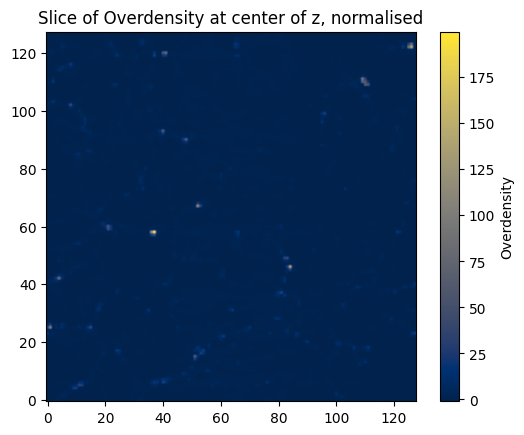

In [5]:
import matplotlib.pyplot as plt

plt.imshow(overdensity[64, :, :], origin='lower', cmap='cividis')
plt.colorbar(label='Overdensity')
plt.title('Slice of Overdensity at center of z, normalised')
plt.show()


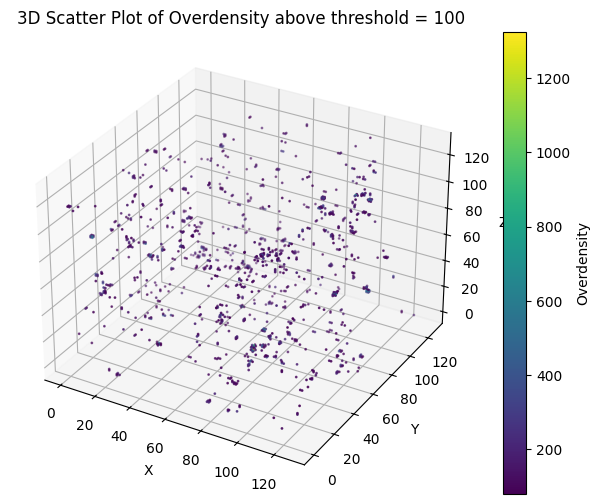

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threshold = 80.0  # only plot points with overdensity > threshold

coords = np.array(np.nonzero(overdensity > threshold)).T
values = overdensity[overdensity > threshold]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=values, cmap='viridis', s=1)
fig.colorbar(p, label='Overdensity')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Scatter Plot of Overdensity above threshold = 100')
plt.show()


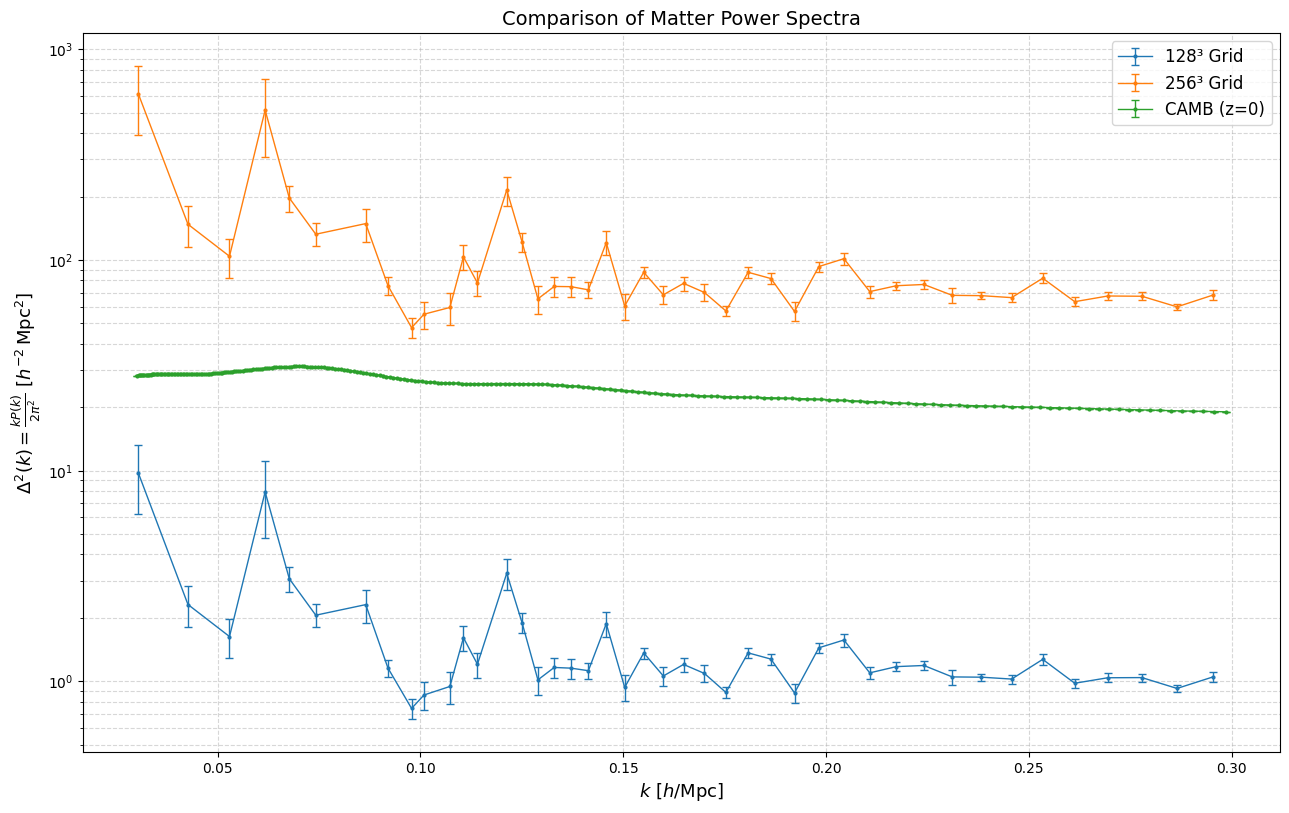

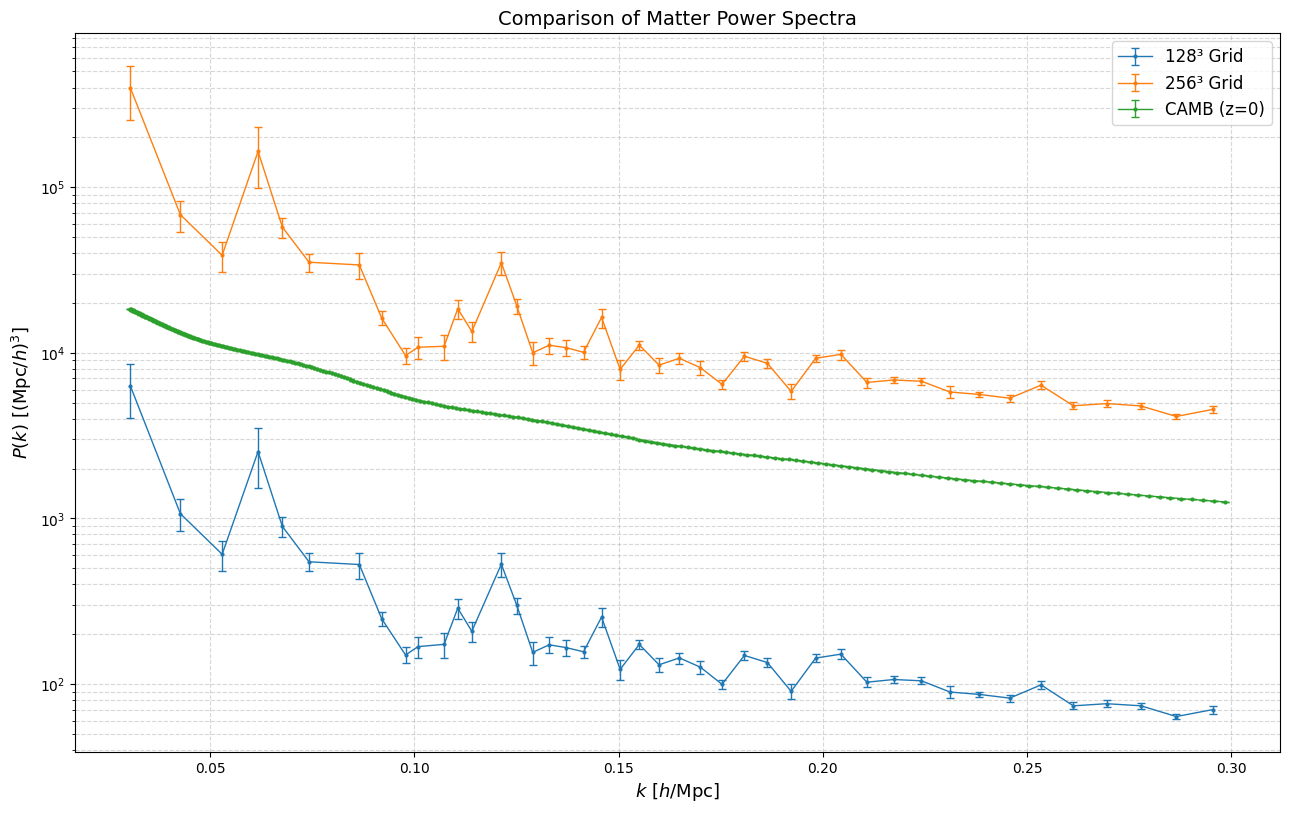

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# NOTE
# the power spectrum seems to be scaled by a factor of hubble's constant. so i have divided the computed values by 0.6774 in the process. it seems to fit better but i do not know why.

def compute_power_spectrum(file_path, L, kmin=0.03, kmax=0.3, num_k_bins=75):
    # Load field
    delta = np.load(file_path)
    N = delta.shape[0]
    V = L**3

    # FFT
    delta_k = np.fft.fftn(delta)
#    delta_k = delta_k*(L/N)**3

    # === Compute k-grid ===
    kfreq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2).flatten()

    # === CIC correction ===
    k_N = np.pi * N / L        # Nyquist frequency
    def sinc(x): 
        result = np.ones_like(x)
        nonzero = x != 0
        result[nonzero] = np.sin(x[nonzero]) / x[nonzero]
        return result

    Wx = sinc(np.pi * kx / (2 * k_N))
    Wy = sinc(np.pi * ky / (2 * k_N))
    Wz = sinc(np.pi * kz / (2 * k_N))
    Wk = (Wx * Wy * Wz)**2
    Wk[Wk == 0] = 1e-20

    # Compute corrected power spectrum
    Pk3D = (np.abs(delta_k)**2 / Wk).flatten() / V

    # === Shot noise correction (CIC) ===
    sin2_x = np.sin(np.pi * kx / (2 * k_N))**2
    sin2_y = np.sin(np.pi * ky / (2 * k_N))**2
    sin2_z = np.sin(np.pi * kz / (2 * k_N))**2
    
    shot_noise = (1/N) * (1 - 2*sin2_x/3) * (1 - 2*sin2_y/3) * (1 - 2*sin2_z/3)
    shot_noise = shot_noise.flatten()
    
    # Subtract shot noise
    Pk3D = Pk3D - shot_noise

    # === Bin in k ===
    k_edges = np.logspace(np.log10(kmin), np.log10(kmax), num_k_bins + 1)
    k_centers = 0.5 * (k_edges[1:] + k_edges[:-1])
    P_binned = np.zeros(num_k_bins)
    P_err = np.zeros(num_k_bins)
    counts = np.zeros(num_k_bins, dtype=int)

    digitized = np.digitize(k_mag, k_edges)
    for i in range(num_k_bins):
        mask = digitized == i + 1
        if np.any(mask):
            P_vals = Pk3D[mask]
            P_binned[i] = P_vals.mean()
            P_err[i] = P_vals.std(ddof=1) / np.sqrt(mask.sum())
            counts[i] = mask.sum()
            P_binned[i] = P_binned[i]/0.6774

    return k_centers, P_binned, P_err


def plot_power_spectrum(k, Pk, P_err, plot_delta2=True):
    plt.figure(figsize=(13,8))
    nonzero = Pk > 0

    if plot_delta2:
        Delta2 = 30*k * Pk / (2 * np.pi**2)
        Delta2_err =k * P_err / (2 * np.pi**2)
        plt.errorbar(k[nonzero], Delta2[nonzero], yerr=Delta2_err[nonzero],
                     fmt='o-', capsize=3, label=r"$k P(k) / 2 \pi^2$")
        plt.ylabel(r"$k P(k) / 2 \pi^2$ [$h^{-2}$ Mpc$^2$]", fontsize=13)
    else:
        plt.errorbar(k[nonzero], Pk[nonzero], yerr=P_err[nonzero],
                     fmt='o-', capsize=3, label=r"$P(k)$")
        plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=13)

    plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=13)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.title("Matter Power Spectrum with Error Bars")
    plt.show()
    
def plot_multiple_power_spectra(results, plot_delta2=True):
    plt.figure(figsize=(13, 8))

    for k, Pk, P_err, label in results:
        nonzero = Pk > 0
        if plot_delta2:
            Delta2 = k * Pk / (2 * np.pi**2)
            Delta2_err = k * P_err / (2 * np.pi**2)
            plt.errorbar(k[nonzero], Delta2[nonzero], yerr=Delta2_err[nonzero],
                         fmt='o-', capsize=3, label=label, markersize=2, linewidth=1)
        else:
            plt.errorbar(k[nonzero], Pk[nonzero], yerr=P_err[nonzero],
                         fmt='o-', capsize=3, label=label, markersize=2, linewidth=1)

    if plot_delta2:
        plt.ylabel(r"$\Delta^2(k) = \frac{k P(k)}{2\pi^2}$ [$h^{-2}\,\mathrm{Mpc}^2$]", fontsize=13)
    else:
        plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=13)

    plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=13)
    plt.xscale('linear')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.title("Comparison of Matter Power Spectra", fontsize=14)
    plt.show()

# === Parameters and execution ===

file_path_1 = '/gpfs/nchugh/dmcoords/tng300_snap99_density_contrast_128^3.npy'
file_path_2 = '/gpfs/nchugh/dmcoords/tng300_snap99_density_contrast_256^3.npy'
L = 302.6*0.6774  # Mpc/h

k_1, Pk_1, P_err_1 = compute_power_spectrum(file_path_1, L)

k_2, Pk_2, P_err_2 = compute_power_spectrum(file_path_2, L)

# Pack into list of results
results = [
    (k_1, Pk_1, P_err_1, "128³ Grid"),
    (k_2, Pk_2, P_err_2, "256³ Grid")
]

import camb
from camb import model

def get_camb_power_spectrum(z=0, kmax=1.0, hubble_param=0.6774, nonlinear=True):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=hubble_param * 100, ombh2=0.0223, omch2=0.119444, mnu=0.06, omk=0, tau=0.0568)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[z], kmax=kmax)
    pars.NonLinear = model.NonLinear_both if nonlinear else model.NonLinear_none
    results = camb.get_results(pars)

    # Get linear or non-linear matter power spectrum
    kh, _, pk = results.get_matter_power_spectrum(minkh=0.01, maxkh=kmax, npoints=500)
    return kh, pk[0]  # pk[0] is for z=0

# === Compute CAMB Power Spectrum ===
k_camb_all, Pk_camb_all = get_camb_power_spectrum(z=0, kmax=1.0, nonlinear=True)

# Apply same k-range cut as simulation (for fair comparison)
kmin, kmax = 0.03, 0.3
mask = (k_camb_all >= kmin) & (k_camb_all <= kmax)
k_camb, Pk_camb = k_camb_all[mask], Pk_camb_all[mask]

# Append CAMB to results
results_with_camb = results + [(k_camb, Pk_camb, np.zeros_like(Pk_camb), "CAMB (z=0)")]

# Plot both over each other
plot_multiple_power_spectra(results_with_camb, plot_delta2=True)   # For Δ²(k)
plot_multiple_power_spectra(results_with_camb, plot_delta2=False)  # For P(k)

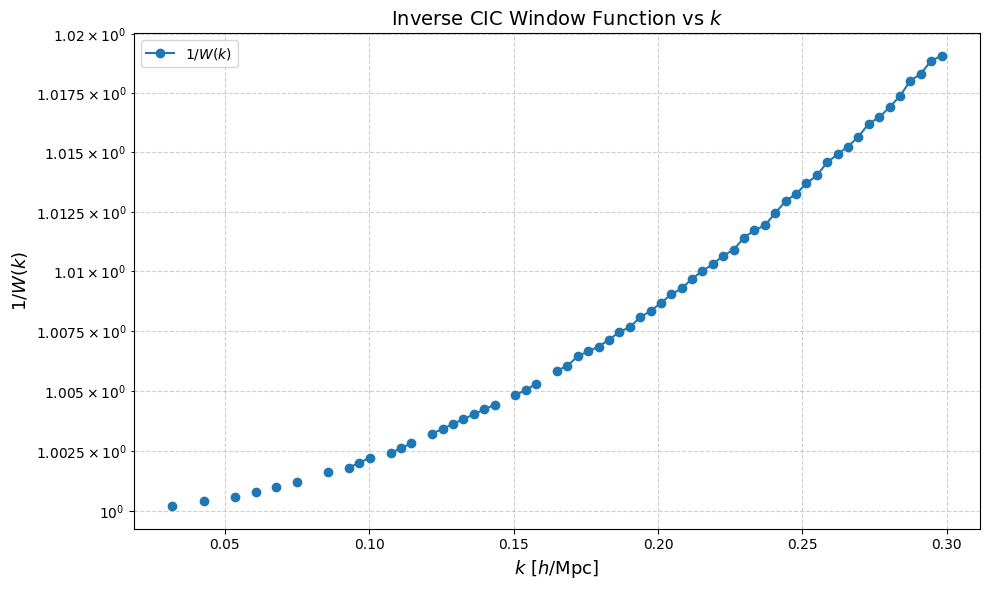

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sinc(x):
    result = np.ones_like(x)
    nonzero = x != 0
    result[nonzero] = np.sin(x[nonzero]) / x[nonzero]
    return result

def plot_inverse_CIC_window(delta, L, kmin=0.03, kmax=0.3, num_k_bins=75):
    N = delta.shape[0]
    k_N = np.pi * N / L  # Nyquist frequency

    # Fourier-space grid
    kfreq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2).flatten()

    # CIC Window Function W(k)
    Wx = sinc(np.pi * kx / (2 * k_N))
    Wy = sinc(np.pi * ky / (2 * k_N))
    Wz = sinc(np.pi * kz / (2 * k_N))
    Wk = (Wx * Wy * Wz)**2
    Wk[Wk == 0] = 1e-20  # avoid division by zero

    # Inverse window function
    inv_Wk = 1.0 / Wk.flatten()

    # Bin in k
    k_edges = np.linspace(kmin, kmax, num_k_bins + 1)
    k_centers = 0.5 * (k_edges[1:] + k_edges[:-1])
    invW_binned = np.zeros(num_k_bins)
    counts = np.zeros(num_k_bins, dtype=int)

    digitized = np.digitize(k_mag, k_edges)
    for i in range(num_k_bins):
        mask = digitized == i + 1
        if np.any(mask):
            invW_binned[i] = inv_Wk[mask].mean()
            counts[i] = mask.sum()
        else:
            invW_binned[i] = np.nan

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(k_centers, invW_binned, 'o-', label=r'$1/W(k)$')
    plt.xscale('linear')
    plt.yscale('log')
    plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize=13)
    plt.ylabel(r'$1/W(k)$', fontsize=13)
    plt.title('Inverse CIC Window Function vs $k$', fontsize=14)
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Usage example ===
# Load your field
delta = np.load('/gpfs/nchugh/dmcoords/tng300_snap99_density_contrast_128^3.npy')
L = 302.6 * 0.6774  # Mpc/h

plot_inverse_CIC_window(delta, L)


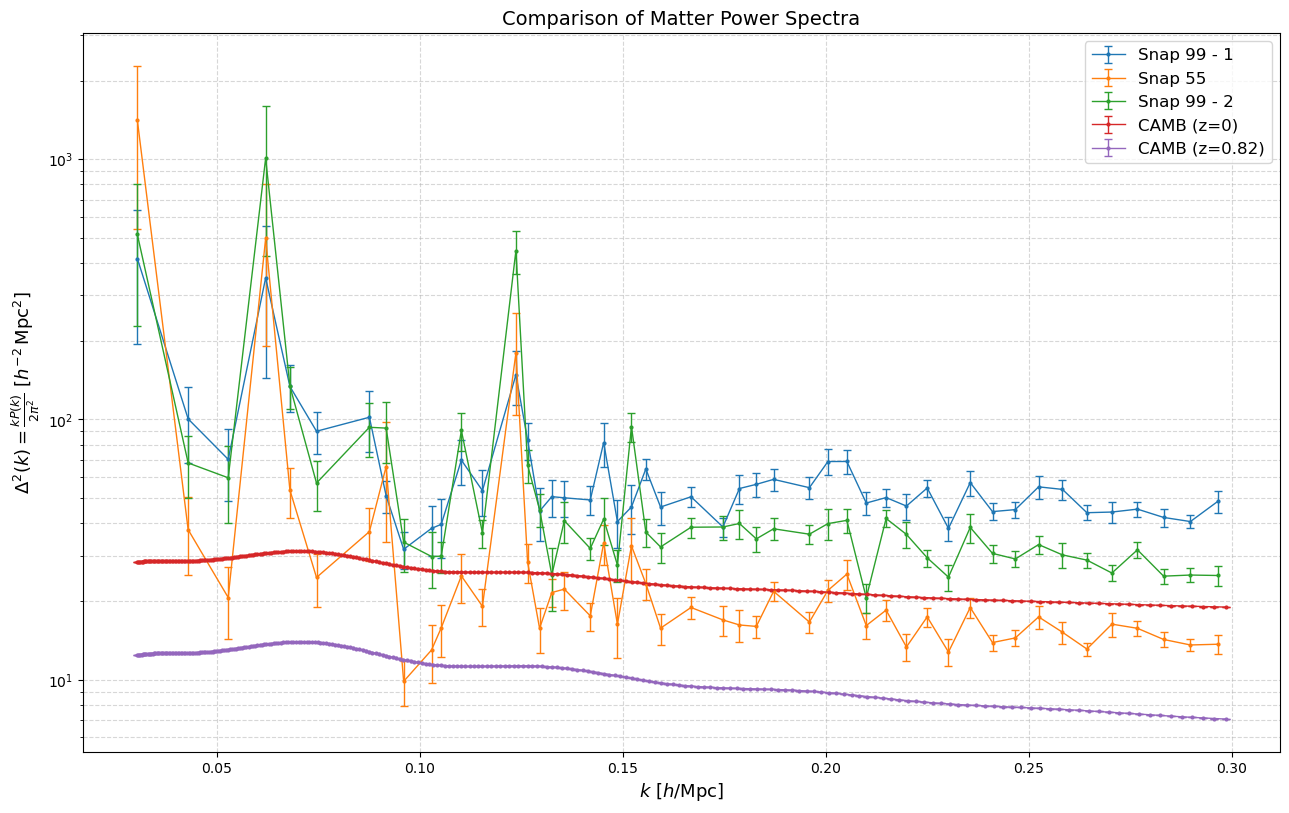

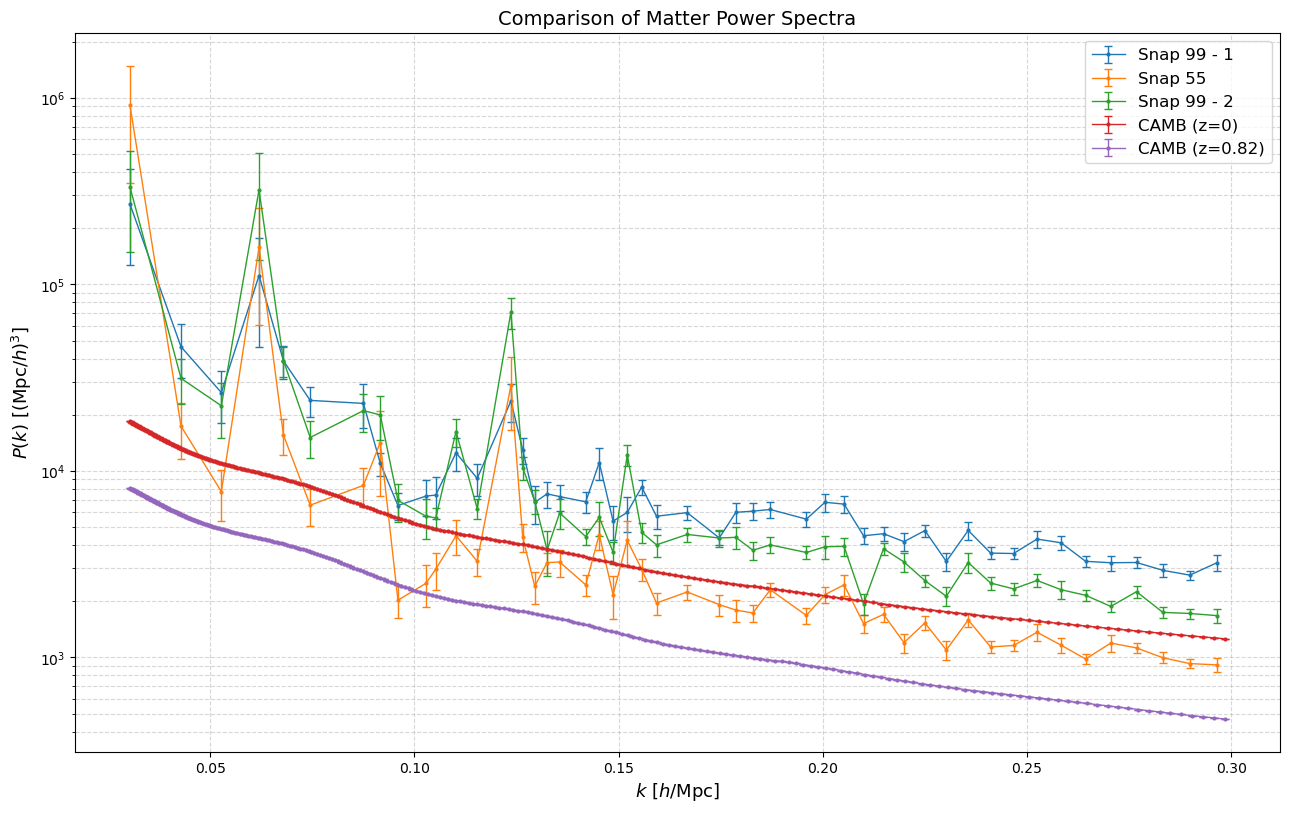

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# NOTE
# the power spectrum seems to be scaled by a factor of hubble's constant. so i have divided the computed values by 0.6774 in the process. it seems to fit better but i do not know why.

def compute_power_spectrum(file_path, L, kmin=0.03, kmax=0.3, num_k_bins=100):
    # Load field
    delta = np.load(file_path)
    N = delta.shape[0] # this feels wrong. it should be number of objects under review? 
    V = L**3
    delta_mean = delta.mean()
    delta = delta/delta_mean - 1

    # FFT
    delta_k = np.fft.fftn(delta)
    delta_k = delta_k

    # === Compute k-grid ===
    kfreq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2).flatten()

    # === CIC correction ===
    k_N = np.pi * N / L        # Nyquist frequency
    def sinc(x): 
        result = np.ones_like(x)
        nonzero = x != 0
        result[nonzero] = np.sin(x[nonzero]) / x[nonzero]
        return result

    Wx = sinc(np.pi * kx / (2 * k_N))
    Wy = sinc(np.pi * ky / (2 * k_N))
    Wz = sinc(np.pi * kz / (2 * k_N))
    Wk = (Wx * Wy * Wz)**2
    Wk[Wk == 0] = 1e-20

    # Compute corrected power spectrum
    Pk3D = (np.abs(delta_k)**2 / Wk).flatten() / V

    # === Shot noise correction (CIC) ===
    sin2_x = np.sin(np.pi * kx / (2 * k_N))**2
    sin2_y = np.sin(np.pi * ky / (2 * k_N))**2
    sin2_z = np.sin(np.pi * kz / (2 * k_N))**2
    
    shot_noise = (1/N) * (1 - 2*sin2_x/3) * (1 - 2*sin2_y/3) * (1 - 2*sin2_z/3)
    shot_noise = shot_noise.flatten()
    
    # Subtract shot noise
    Pk3D = Pk3D - shot_noise

    # === Bin in k ===
    k_edges = np.logspace(np.log10(kmin), np.log10(kmax), num_k_bins + 1)
    k_centers = 0.5 * (k_edges[1:] + k_edges[:-1])
    P_binned = np.zeros(num_k_bins)
    P_err = np.zeros(num_k_bins)
    counts = np.zeros(num_k_bins, dtype=int)

    digitized = np.digitize(k_mag, k_edges)
    for i in range(num_k_bins):
        mask = digitized == i + 1
        if np.any(mask):
            P_vals = Pk3D[mask]
            P_binned[i] = P_vals.mean()
            P_err[i] = P_vals.std(ddof=1) / np.sqrt(mask.sum())
            counts[i] = mask.sum()
#            P_binned[i] *= 0.6774

    return k_centers, P_binned, P_err


def plot_power_spectrum(k, Pk, P_err, plot_delta2=True):
    plt.figure(figsize=(13,8))
    nonzero = Pk > 0

    if plot_delta2:
        Delta2 = k * Pk / (2 * np.pi**2)
        Delta2_err =k * P_err / (2 * np.pi**2)
        plt.errorbar(k[nonzero], Delta2[nonzero], yerr=Delta2_err[nonzero],
                     fmt='o-', capsize=3, label=r"$k P(k) / 2 \pi^2$")
        plt.ylabel(r"$k P(k) / 2 \pi^2$ [$h^{-2}$ Mpc$^2$]", fontsize=13)
    else:
        plt.errorbar(k[nonzero], Pk[nonzero], yerr=P_err[nonzero],
                     fmt='o-', capsize=3, label=r"$P(k)$")
        plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=13)

    plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=13)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.title("Matter Power Spectrum with Error Bars")
    plt.show()
    
def plot_multiple_power_spectra(results, plot_delta2=True):
    plt.figure(figsize=(13, 8))

    for k, Pk, P_err, label in results:
        nonzero = Pk > 0
        if plot_delta2:
            Delta2 = k * Pk / (2 * np.pi**2)
            Delta2_err = k * P_err / (2 * np.pi**2)
            plt.errorbar(k[nonzero], Delta2[nonzero], yerr=Delta2_err[nonzero],
                         fmt='o-', capsize=3, label=label, markersize=2, linewidth=1)
        else:
            plt.errorbar(k[nonzero], Pk[nonzero], yerr=P_err[nonzero],
                         fmt='o-', capsize=3, label=label, markersize=2, linewidth=1)

    if plot_delta2:
        plt.ylabel(r"$\Delta^2(k) = \frac{k P(k)}{2\pi^2}$ [$h^{-2}\,\mathrm{Mpc}^2$]", fontsize=13)
    else:
        plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=13)

    plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=13)
    plt.xscale('linear')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.title("Comparison of Matter Power Spectra", fontsize=14)
    plt.show()

# === Parameters and execution ===

file_path_1 = '/gpfs/nchugh/dmcoordssnaps/snap-99/tng300_snap99_density_field_256^3.npy'
file_path_2 = '/gpfs/nchugh/dmcoordssnaps/snap-55/tng300_snap55_density_field_256^3.npy'
file_path_3 = '/gpfs/nchugh/dmcoords/field.npy'

L = 302.6*0.6774  # Mpc/h

k_1, Pk_1, P_err_1 = compute_power_spectrum(file_path_1, L)

k_2, Pk_2, P_err_2 = compute_power_spectrum(file_path_2, L)

k_3, Pk_3, P_err_3 = compute_power_spectrum(file_path_3, L)

# Pack into list of results
results = [
    (k_1, Pk_1, P_err_1, "Snap 99 - 1"),
    (k_2, Pk_2, P_err_2, "Snap 55")
    , (k_3, Pk_3, P_err_3, "Snap 99 - 2")
]

import camb
from camb import model

def get_camb_power_spectrum(z=0, kmax=1.0, hubble_param=0.6774, nonlinear=True):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=hubble_param * 100, ombh2=0.0223, omch2=0.119444, mnu=0.06, omk=0, tau=0.0568)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[z], kmax=kmax)
    pars.NonLinear = model.NonLinear_both if nonlinear else model.NonLinear_none
    results = camb.get_results(pars)

    # Get linear or non-linear matter power spectrum
    kh, _, pk = results.get_matter_power_spectrum(minkh=0.01, maxkh=kmax, npoints=500)
    return kh, pk[0]  # pk[0] is for z=0

# === Compute CAMB Power Spectrum ===
k_camb_all, Pk_camb_all = get_camb_power_spectrum(z=0, kmax=1.0, nonlinear=True)

# Apply same k-range cut as simulation (for fair comparison)
kmin, kmax = 0.03, 0.3
mask = (k_camb_all >= kmin) & (k_camb_all <= kmax)
k_camb1, Pk_camb1 = k_camb_all[mask], Pk_camb_all[mask]

k_camb_all, Pk_camb_all = get_camb_power_spectrum(z=0.82, kmax=1.0, nonlinear=True)

# Apply same k-range cut as simulation (for fair comparison)
mask = (k_camb_all >= kmin) & (k_camb_all <= kmax)
k_camb2, Pk_camb2 = k_camb_all[mask], Pk_camb_all[mask]

# Append CAMB to results
results_with_camb = results + [(k_camb1, Pk_camb1, np.zeros_like(Pk_camb1), "CAMB (z=0)"),
                                (k_camb2, Pk_camb2, np.zeros_like(Pk_camb2), "CAMB (z=0.82)")]

# Plot both over each other
plot_multiple_power_spectra(results_with_camb, plot_delta2=True)   # For Δ²(k)
plot_multiple_power_spectra(results_with_camb, plot_delta2=False)  # For P(k)

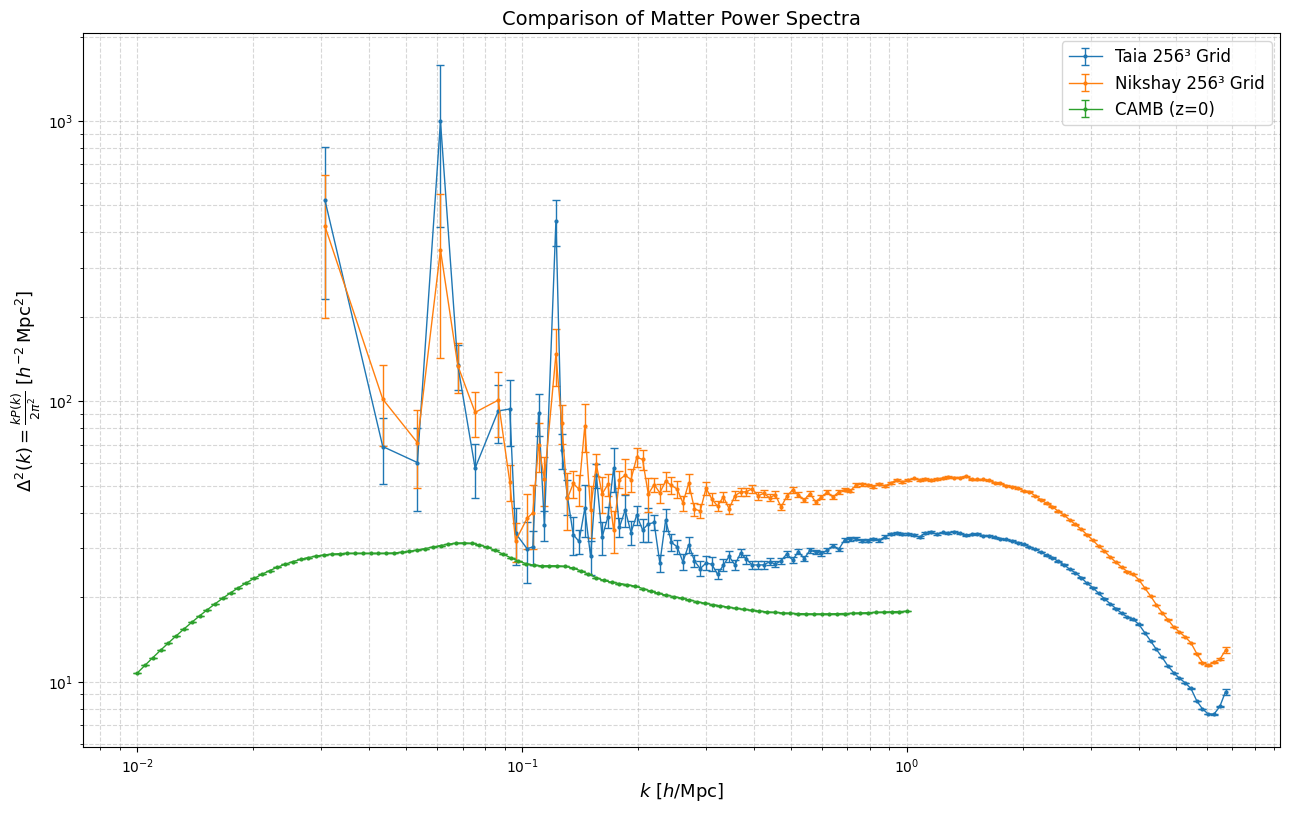

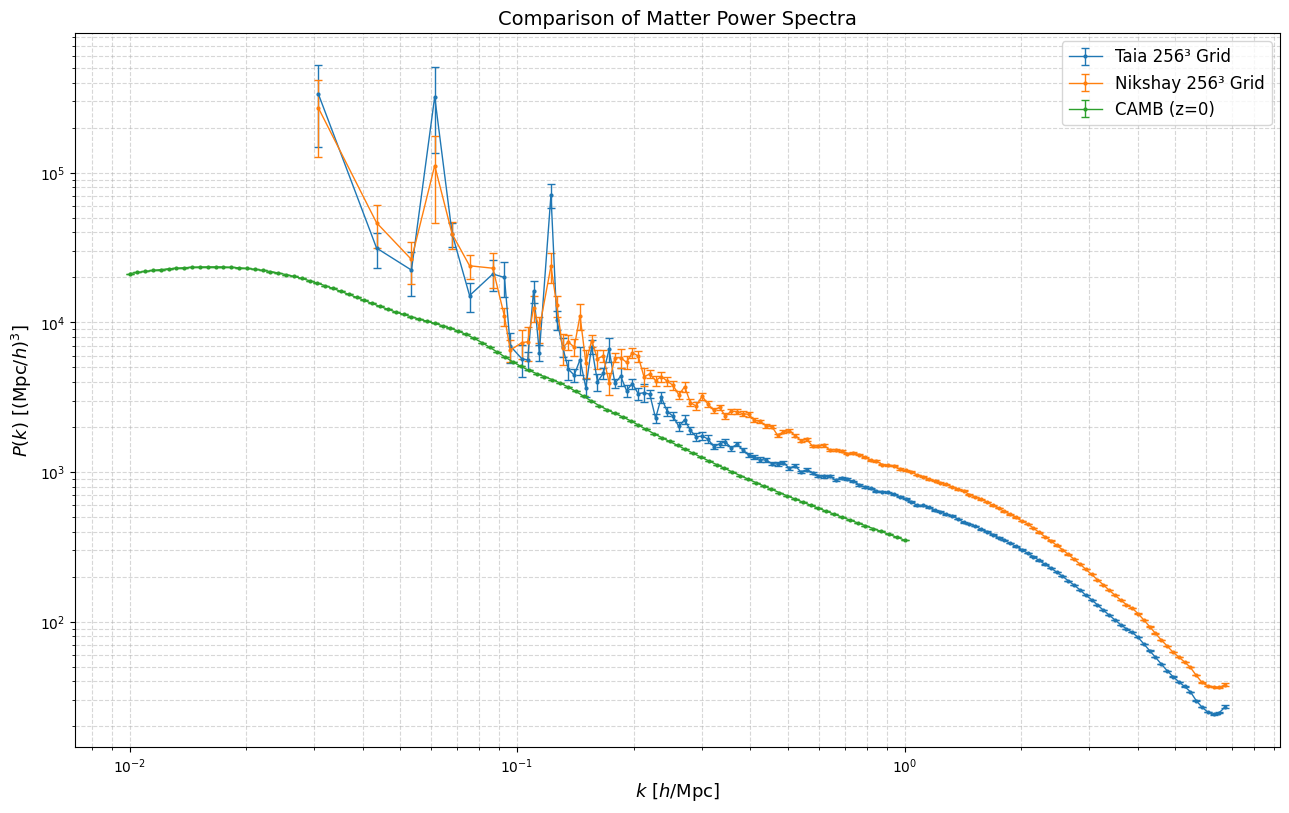

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# NOTE
# the power spectrum seems to be scaled by a factor of hubble's constant. so i have divided the computed values by 0.6774 in the process. it seems to fit better but i do not know why.

def compute_power_spectrum(file_path, L, kmin=0.01, kmax=10, num_k_bins=200):
    # Load field
    delta = np.load(file_path)
    N = delta.shape[0] # this feels wrong. 
    V = L**3
    delta_mean = delta.mean()
    delta = delta/delta_mean - 1

    # FFT
    delta_k = np.fft.fftn(delta)
    delta_k = delta_k

    # === Compute k-grid ===
    kfreq = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k_mag = np.sqrt(kx**2 + ky**2 + kz**2).flatten()

    # === CIC correction ===
    k_N = np.pi * N / L        # Nyquist frequency
    def sinc(x): 
        result = np.ones_like(x)
        nonzero = x != 0
        result[nonzero] = np.sin(x[nonzero]) / x[nonzero]
        return result

    Wx = sinc(np.pi * kx / (2 * k_N))
    Wy = sinc(np.pi * ky / (2 * k_N))
    Wz = sinc(np.pi * kz / (2 * k_N))
    Wk = (Wx * Wy * Wz)**2
    Wk[Wk == 0] = 1e-20

    # Compute corrected power spectrum
    Pk3D = (np.abs(delta_k)**2 / Wk).flatten() / V

    # === Shot noise correction (CIC) ===
    sin2_x = np.sin(np.pi * kx / (2 * k_N))**2
    sin2_y = np.sin(np.pi * ky / (2 * k_N))**2
    sin2_z = np.sin(np.pi * kz / (2 * k_N))**2
    
    shot_noise = (1/N) * (1 - 2*sin2_x/3) * (1 - 2*sin2_y/3) * (1 - 2*sin2_z/3)
    shot_noise = shot_noise.flatten()
    
    # Subtract shot noise
    Pk3D = Pk3D - shot_noise

    # === Bin in k ===
    k_edges = np.logspace(np.log10(kmin), np.log10(kmax), num_k_bins + 1)
    k_centers = 0.5 * (k_edges[1:] + k_edges[:-1])
    P_binned = np.zeros(num_k_bins)
    P_err = np.zeros(num_k_bins)
    counts = np.zeros(num_k_bins, dtype=int)

    digitized = np.digitize(k_mag, k_edges)
    for i in range(num_k_bins):
        mask = digitized == i + 1
        if np.any(mask):
            P_vals = Pk3D[mask]
            P_binned[i] = P_vals.mean()
            P_err[i] = P_vals.std(ddof=1) / np.sqrt(mask.sum())
            counts[i] = mask.sum()
#            P_binned[i] *= 0.6774

    return k_centers, P_binned, P_err


def plot_power_spectrum(k, Pk, P_err, plot_delta2=True):
    plt.figure(figsize=(13,8))
    nonzero = Pk > 0

    if plot_delta2:
        Delta2 = k * Pk / (2 * np.pi**2)
        Delta2_err =k * P_err / (2 * np.pi**2)
        plt.errorbar(k[nonzero], Delta2[nonzero], yerr=Delta2_err[nonzero],
                     fmt='o-', capsize=3, label=r"$k P(k) / 2 \pi^2$")
        plt.ylabel(r"$k P(k) / 2 \pi^2$ [$h^{-2}$ Mpc$^2$]", fontsize=13)
    else:
        plt.errorbar(k[nonzero], Pk[nonzero], yerr=P_err[nonzero],
                     fmt='o-', capsize=3, label=r"$P(k)$")
        plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=13)

    plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=13)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.title("Matter Power Spectrum with Error Bars")
    plt.show()
    
def plot_multiple_power_spectra(results, plot_delta2=True):
    plt.figure(figsize=(13, 8))

    for k, Pk, P_err, label in results:
        nonzero = Pk > 0
        if plot_delta2:
            Delta2 = k * Pk / (2 * np.pi**2)
            Delta2_err = k * P_err / (2 * np.pi**2)
            plt.errorbar(k[nonzero], Delta2[nonzero], yerr=Delta2_err[nonzero],
                         fmt='o-', capsize=3, label=label, markersize=2, linewidth=1)
        else:
            plt.errorbar(k[nonzero], Pk[nonzero], yerr=P_err[nonzero],
                         fmt='o-', capsize=3, label=label, markersize=2, linewidth=1)

    if plot_delta2:
        plt.ylabel(r"$\Delta^2(k) = \frac{k P(k)}{2\pi^2}$ [$h^{-2}\,\mathrm{Mpc}^2$]", fontsize=13)
    else:
        plt.ylabel(r"$P(k)$ [$(\mathrm{Mpc}/h)^3$]", fontsize=13)

    plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=13)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.title("Comparison of Matter Power Spectra", fontsize=14)
    plt.show()

# === Parameters and execution ===

file_path_1 = '/gpfs/nchugh/dmcoords/field.npy'
file_path_2 = '/gpfs/nchugh/dmcoords/tng300_snap99_density_field_256^3.npy'
L = 302.6*0.6774  # Mpc/h

k_1, Pk_1, P_err_1 = compute_power_spectrum(file_path_1, L)

k_2, Pk_2, P_err_2 = compute_power_spectrum(file_path_2, L)

# Pack into list of results
results = [
    (k_1, Pk_1, P_err_1, "Taia 256³ Grid"),
    (k_2, Pk_2, P_err_2, "Nikshay 256³ Grid")
]

import camb
from camb import model

def get_camb_power_spectrum(z=0, kmax=1.0, hubble_param=0.6774, var1='delta_nonu', var2= 'delta_nonu', nonlinear=True):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=hubble_param * 100, ombh2=0.0223, omch2=0.119444, mnu=0.06, omk=0, tau=0.0568)
    pars.InitPower.set_params(As=2e-9, ns=0.965)
    pars.set_matter_power(redshifts=[z], kmax=kmax)
    pars.NonLinear = model.NonLinear_both if nonlinear else model.NonLinear_none
    results = camb.get_results(pars)

    # Get linear or non-linear matter power spectrum
    kh, _, pk = results.get_matter_power_spectrum(minkh=0.01, maxkh=kmax, npoints=100)
    return kh, pk[0]  # pk[0] is for z=0

# === Compute CAMB Power Spectrum ===
k_camb_all, Pk_camb_all = get_camb_power_spectrum(z=0, kmax=1.0, nonlinear=True)

# Apply same k-range cut as simulation (for fair comparison)
kmin, kmax = 0.01, 10
mask = (k_camb_all >= kmin) & (k_camb_all <= kmax)
k_camb, Pk_camb = k_camb_all[mask], Pk_camb_all[mask]

# Append CAMB to results
results_with_camb = results + [(k_camb, Pk_camb, np.zeros_like(Pk_camb), "CAMB (z=0)")]

# Plot both over each other
plot_multiple_power_spectra(results_with_camb, plot_delta2=True)   # For Δ²(k)
plot_multiple_power_spectra(results_with_camb, plot_delta2=False)  # For P(k)

In [4]:
file_path_1 = '/gpfs/nchugh/dmcoords/field.npy'
delta = np.load(file_path_1)
N= delta.shape[0]
print(N)

256


In [2]:
import numpy as np
import glob
import os

# Grid setup
snap = 55
nx = ny = nz = 256
ngrid = (nx, ny, nz)
field = np.zeros((nx, ny, nz), dtype=np.float32)

# Base directory
base_path = f"/gpfs/nchugh/dmcoordssnaps/snap-{snap}"
coord_files = sorted(glob.glob(os.path.join(base_path, "coords_*.npy")))
print(f"Found {len(coord_files)} coordinate files")

# --- CIC function (complete) ---
import numpy as np
from numba import njit, prange

@njit(parallel=True, fastmath=True)
def cic_numba(value, x, y, z, nx, ny, nz, average):
    n = x.shape[0]
    field = np.zeros(nx * ny * nz, dtype=np.float32)
    totalweight = np.zeros_like(field) if average else None

    nxny = nx * ny

    for i in prange(n):
        # Find nearest grid points and weights per axis (exactly your logic)
        for axis_pos, ngrid in zip((x[i], y[i], z[i]), (nx, ny, nz)):
            pass  # We'll inline the logic below instead of function call for speed

        # X-axis weights and indices
        pos = x[i]
        ngp = np.floor(pos + 0.5) if True else np.floor(pos) + 0.5
        distngp = ngp - pos
        w2x = abs(distngp)
        w1x = 1.0 - w2x
        ind1x = int(ngp)
        ind2x = ind1x - 1
        if distngp < 0:
            ind2x += 2
        if ind2x == -1:
            ind2x = nx - 1
            if not True:
                w2x = 0.0
        if ind2x == nx:
            ind2x = 0
            if not True:
                w2x = 0.0
        if ind1x == nx:
            ind1x = 0

        # Y-axis
        pos = y[i]
        ngp = np.floor(pos + 0.5) if True else np.floor(pos) + 0.5
        distngp = ngp - pos
        w2y = abs(distngp)
        w1y = 1.0 - w2y
        ind1y = int(ngp)
        ind2y = ind1y - 1
        if distngp < 0:
            ind2y += 2
        if ind2y == -1:
            ind2y = ny - 1
            if not True:
                w2y = 0.0
        if ind2y == ny:
            ind2y = 0
            if not True:
                w2y = 0.0
        if ind1y == ny:
            ind1y = 0

        # Z-axis
        pos = z[i]
        ngp = np.floor(pos + 0.5) if True else np.floor(pos) + 0.5
        distngp = ngp - pos
        w2z = abs(distngp)
        w1z = 1.0 - w2z
        ind1z = int(ngp)
        ind2z = ind1z - 1
        if distngp < 0:
            ind2z += 2
        if ind2z == -1:
            ind2z = nz - 1
            if not True:
                w2z = 0.0
        if ind2z == nz:
            ind2z = 0
            if not True:
                w2z = 0.0
        if ind1z == nz:
            ind1z = 0

        # Accumulate on 8 surrounding grid points
        wts = np.array([
            w1x * w1y * w1z,
            w2x * w1y * w1z,
            w1x * w2y * w1z,
            w2x * w2y * w1z,
            w1x * w1y * w2z,
            w2x * w1y * w2z,
            w1x * w2y * w2z,
            w2x * w2y * w2z,
        ], dtype=np.float32)

        ix = np.array([ind1x, ind2x, ind1x, ind2x, ind1x, ind2x, ind1x, ind2x])
        iy = np.array([ind1y, ind1y, ind2y, ind2y, ind1y, ind1y, ind2y, ind2y])
        iz = np.array([ind1z, ind1z, ind1z, ind1z, ind2z, ind2z, ind2z, ind2z])

        val = value[i]

        for k in range(8):
            idx = ix[k] + iy[k] * nx + iz[k] * nxny
            field[idx] += wts[k] * val
            if average:
                totalweight[idx] += wts[k]

    if average:
        for i in range(field.size):
            if totalweight[i] > 0:
                field[i] /= totalweight[i]

    return field.reshape((nx, ny, nz)).transpose()

# --- Main loop ---
for i, coord_file in enumerate(coord_files):
    try:
        coords_std = np.load(coord_file)
        vals = np.ones(coords_std.shape[0], dtype=np.float32)

        # Clip coordinates to grid range
        coords_std = np.clip(coords_std, 0, [nx - 1e-6, ny - 1e-6, nz - 1e-6])

        partial_field = cic(vals,
                            coords_std[:, 0], nx,
                            coords_std[:, 1], ny,
                            coords_std[:, 2], nz,
                            average=False)
        field += partial_field
        print(f"Processed file {i+1}/{len(coord_files)}: {os.path.basename(coord_file)}")
    except Exception as e:
        print(f"Error reading {coord_file}: {e}")

# --- Save final result ---
output_file = os.path.join(base_path, f"field_{snap}_256.npy")
np.save(output_file, field)
print(f"\n✅ Saved final density field to '{output_file}'")


Found 600 coordinate files
Processed file 1/600: coords_000.npy
Processed file 2/600: coords_001.npy
Processed file 3/600: coords_002.npy


KeyboardInterrupt: 